This code imputs different values in the SMRT model and simpel tiepoint model $\newline$
The goal is to find values where the models are in agreement

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os

In [2]:
ice_type = 'multiyear' # firstyear or multiyear sea ice
#smrt_profile inputs: snow depth, ice thickness, surface temperature, ice type,
    


# Tiepoint model

In [3]:
#tie-point model for ice and open water
def tiepoint(snedybde, istykkelse, overfladetemperatur, iskoncentration):
    #the mar+april 2013 model
    #Tb for sea ice
    #overfladetemperatur [K]
    #snedybde [m]
    #istykkelse [m]
    #iskoncentration [0-1]
    T6vsi = 151.981 + 0.398 * overfladetemperatur+ 23.360 * snedybde -3.031 * istykkelse
    T6hsi = 55.262 + 0.687 * overfladetemperatur+ 12.962 * snedybde -1.664 * istykkelse
    T10vsi = 145.878 + 0.435 * overfladetemperatur+ 0.743 * snedybde -4.202 * istykkelse
    T10hsi = 45.107 + 0.753 * overfladetemperatur -18.7322 * snedybde -3.490 * istykkelse
    T18vsi = 138.073 + 0.479 * overfladetemperatur -71.814 * snedybde -5.570 * istykkelse
    T18hsi = 78.424 + 0.641 * overfladetemperatur -85.184 * snedybde -5.341 * istykkelse
    T36vsi = 123.102 + 0.526 * overfladetemperatur -216.727 * snedybde -4.036 * istykkelse
    T36hsi = 131.862 + 0.429 * overfladetemperatur -214.352 * snedybde -3.035 * istykkelse
    T89vsi = 2.525 + 0.902 * overfladetemperatur -180.427 * snedybde+ 1.904 * istykkelse
    T89hsi = 31.120 + 0.743 * overfladetemperatur -184.806 * snedybde+ 3.197 * istykkelse
    #Tb for open water
    T6vow=161.35
    T6how=82.13
    T10vow=167.34
    T10how=88.26
    T18vow=183.72
    T18how=108.46
    T36vow=196.41
    T36how=128.23
    T89vow=243.20
    T89how=196.94
    #Tb for ice and open water
    T6vsim  = iskoncentration*T6vsi  + (1-iskoncentration)*T6vow
    T6hsim  = iskoncentration*T6hsi  + (1-iskoncentration)*T6how
    T10vsim = iskoncentration*T10vsi + (1-iskoncentration)*T10vow
    T10hsim = iskoncentration*T10hsi + (1-iskoncentration)*T10how
    T18vsim = iskoncentration*T18vsi + (1-iskoncentration)*T18vow
    T18hsim = iskoncentration*T18hsi + (1-iskoncentration)*T18how
    T36vsim = iskoncentration*T36vsi + (1-iskoncentration)*T36vow
    T36hsim = iskoncentration*T36hsi + (1-iskoncentration)*T36how    
    T89vsim = iskoncentration*T89vsi + (1-iskoncentration)*T89vow
    T89hsim = iskoncentration*T89hsi + (1-iskoncentration)*T89how    
        
    Tbv=np.array([[T6vsim,T10vsim,T18vsim,T36vsim,T89vsim]])
    Tbh=np.array([[T6hsim,T10hsim,T18hsim,T36hsim,T89hsim]])
    return Tbv, Tbh

# SMRT

In [4]:
def smrt_profile(snowt,icet,Ts,icetype):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface
    #icetype: first- or multiyear ice ['firstyear'/'multiyear']
    
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    total_depth=int(hs+hi)
    num=np.array(range(total_depth))
    num=num+1
    
    #compute layer thickness
    di=0.01*np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(int(hs))
    icetemp=np.zeros(int(hi))
    Tw=271.35
    ks=0.3
    ki=2.1
    #snedybden skal ikke være null her
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1)
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi
        Ti[0:hs]=snowtemp[:]
        Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=330.0
    else:
        snow_density[0:w]=250.0
        snow_density[w:]=330.0
        snow_density=np.flipud(snow_density)
        
    ice_density=np.zeros(hi)
    #First-year ice density (icethickness)
    if icetype=='firstyear': 
        ice_density[:]=926.0
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='multiyear':
        humdens=np.zeros(20)
        tdens=750.0
        bdens=910.0
        for i in range(20):
            humdens[i]=tdens+i*(bdens-tdens)/20
        ice_density[0:20]=humdens[:]
        ice_density[20:hi]=bdens
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    snow_grain_size = 20
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='firstyear': ice_pcc[:]=0.1
    elif icetype=='multiyear': 
        ice_pcc[0:20]=0.8
        ice_pcc[20:hi]=0.2
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=7.88-1.59*(hi/100.0)
    
    #First-year ice snow and ice salinity
    if icetype=='firstyear':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi)
    elif icetype=='multiyear':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi
    sal[0:hs]=np.flipud(snow_sal[:])
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='firstyear': ice_type[:]=3
    elif icetype=='multiyear': ice_type[:]=4
    
    typei[0:hs]=snow_type[:]
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    return num, di, Ti, Wi, roi, pci, sal, typei, si

In [5]:
sys.path.append("/Users\fnifd\Documents\BachelorProject\smrt\smrt-master")
#export PYTHONPATH=$PYTHONPATH: \Users\fnifd\Documents\BachelorProject\smrt\smrt-master

# local import
from smrt import make_ice_column, make_snowpack, make_model, sensor_list
from smrt import PSU
from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09
#from smrt.inputs.make_medium import make_ice_column
ice_type = 'multiyear' # firstyear or multiyear sea ice
#smrt_profile inputs: snow depth, ice thickness, surface temperature, ice type, returns profiles
[num, di, Ti, Wi, roi, pci, sal, typei, si] = smrt_profile(0.15,2.5,250,ice_type)
#split into snow and sea ice indices
snow=(si==0)
ice=(si==1)

#the profiles: snow
thickness_snow=di[snow]
density_snow=roi[snow]
temperature_snow=Ti[snow]
p_ex_snow=pci[snow]*1e-3
salinity_snow=sal[snow]*PSU

#profiles: ice
thickness_ice=di[ice]
temperature_ice=Ti[ice]
salinity_ice=sal[ice]*PSU
density_ice=roi[ice]
p_ex_ice=pci[ice]*1e-3


ice_column = make_ice_column(ice_type=ice_type,
                            thickness=thickness_ice,
                            temperature=temperature_ice,
                            microstructure_model="exponential",
                            brine_inclusion_shape="spheres", 
                            salinity=salinity_ice, 
                            density = density_ice,
                            corr_length=p_ex_ice,
                            add_water_substrate="ocean"
                            )


snowpack = make_snowpack(thickness=thickness_snow,
                         microstructure_model="exponential",
                         density=density_snow,
                         temperature=temperature_snow,
                         corr_length=p_ex_snow,
                         salinity=salinity_snow,
                         ice_permittivity_model=saline_snow_permittivity_geldsetzer09)



#add snowpack on top of ice column:
medium = snowpack + ice_column

# create the sensor
sensor = sensor_list.amsre()

#n_max_stream = 128 #TB calculation is more accurate if number of streams is increased (currently: default = 32);
n_max_stream=32
#needs to be increased when using > 1 snow layer on top of sea ice! normalization="forced"
m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream})
print('2')

# run the model for snow-covered sea ice:
brightness_temperatures = m.run(sensor, medium)

print('3')

# print TBs at horizontal and vertical polarization Tb's:
#print(brightness_temperatures.TbH(), brightness_temperatures.TbV())
tbv=brightness_temperatures.TbV()
tbh=brightness_temperatures.TbH()
tv_no23=np.array([[tbv[0],tbv[1],tbv[2],tbv[4],tbv[5]]])
th_no23=np.array([[tbh[0],tbh[1],tbh[2],tbh[4],tbh[5]]])
print(' ')
print(tv_no23)
print(th_no23)

2
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D0BDDF0>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D0BDDF0>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D0BDDF0>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D0BDDF0>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D0BDDF0>


C:\Users\fnifd\anaconda3\envs\Bachelor\lib\site-packages\smrt\permittivity\saline_snow.py:29: UserWarning: The permittivity model of Geldsetzer et al. 2009 (doi:10.1016/j.coldregions.2009.03.009) was developed for the frequency range 10 MHz - 40 GHz.
  warnings.warn(


SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D0BDDF0>
3
 
[[260.14715689 254.32696704 232.42027387 197.01148384 195.78344748]]
[[226.64047272 221.37798943 201.703987   173.96394059 179.83183403]]


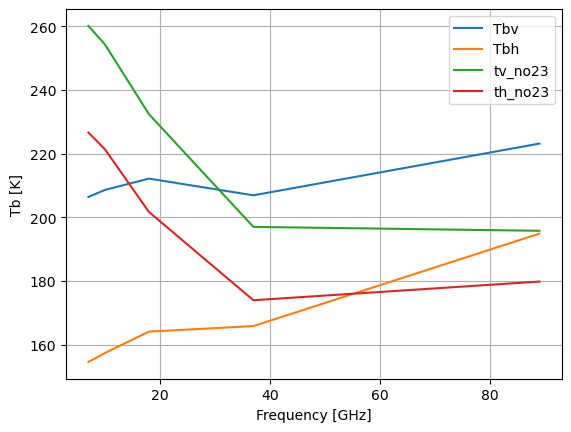

In [6]:
freqs=np.array([7,10,18,37,89])
#plt.plot(freqs,brightness_temperatures.TbV())
#plt.plot(freqs,brightness_temperatures.TbH())
Tbv,Tbh=tiepoint(0.15,1.15,250,.5)
plt.plot(freqs,Tbv[0], label = 'Tbv')
plt.plot(freqs,Tbh[0], label = 'Tbh')
plt.plot(freqs,tv_no23[0], label = 'tv_no23')
plt.plot(freqs,th_no23[0], label = 'th_no23')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Tb [K]')
plt.legend()
plt.grid()
plt.show()

In [7]:
sys.path.append("/Users\fnifd\Documents\BachelorProject\smrt\smrt-master")
#export PYTHONPATH=$PYTHONPATH: \Users\fnifd\Documents\BachelorProject\smrt\smrt-master

# local import
from smrt import make_ice_column, make_snowpack, make_model, sensor_list
from smrt import PSU

# create the sensor
sensor = sensor_list.amsre()

#n_max_stream = 128 #TB calculation is more accurate if number of streams is increased (currently: default = 32);
n_max_stream=32
#needs to be increased when using > 1 snow layer on top of sea ice! normalization="forced"from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09

def run_smrt(snow_depth,ice_thickness,surf_temp,ice_type):

    #smrt_profile inputs: snow depth, ice thickness, surface temperature, ice type, returns profiles
    [num, di, Ti, Wi, roi, pci, sal, typei, si] = smrt_profile(snow_depth,ice_thickness,surf_temp,ice_type)
    #split into snow and sea ice indices
    snow=(si==0)
    ice=(si==1)


    ice_column = make_ice_column(ice_type=ice_type,
                            thickness=di[ice],
                            temperature=Ti[ice],
                            microstructure_model="exponential",
                            brine_inclusion_shape="spheres", 
                            salinity=sal[ice]*PSU, 
                            density = roi[ice],
                            corr_length=pci[ice]*1e-3,
                            add_water_substrate="ocean"
                            )
    
    snowpack = make_snowpack(thickness=di[snow],
                         microstructure_model="exponential",
                         density=roi[snow],
                         temperature=Ti[snow],
                         corr_length=pci[snow]*1e-3,
                         salinity=sal[snow]*PSU,
                         ice_permittivity_model=saline_snow_permittivity_geldsetzer09)


    #add snowpack on top of ice column:
    medium = snowpack + ice_column

    m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream})

    # run the model for snow-covered sea ice:
    brightness_temperatures = m.run(sensor, medium)

    # print TBs at horizontal and vertical polarization Tb's:
    #print(brightness_temperatures.TbH(), brightness_temperatures.TbV())
    tbv=brightness_temperatures.TbV()
    tbh=brightness_temperatures.TbH()
    tv_no23=np.array([[tbv[0],tbv[1],tbv[2],tbv[4],tbv[5]]])
    th_no23=np.array([[tbh[0],tbh[1],tbh[2],tbh[4],tbh[5]]])
    return tv_no23, th_no23

In [8]:
freqs=np.array([7,10,18,37,89])
#plt.plot(freqs,brightness_temperatures.TbV())
#plt.plot(freqs,brightness_temperatures.TbH())

#from smrt.inputs.make_medium import make_ice_column
ice_type = 'multiyear' # firstyear or multiyear sea ice

snowDepth = 0.55 # HS
iceThickness = 1.15 # HI
surfTemp = 270 # Tsnz
iceConc = 1 # 
iceType = 'multiyear'

smrtV,smrtH = run_smrt(snowDepth,iceThickness,surfTemp,iceType)
TbV,TbH = tiepoint(snowDepth,iceThickness,surfTemp,iceConc)

score = abs(smrtV - TbV) + abs(smrtH - TbH)

print(score)
print(np.mean(score))

SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D966E50>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D966E50>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D966E50>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D966E50>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D966E50>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1D966E50>
[[ 10.3528353    6.75706126  59.98812885 195.7316565  162.37499888]]
87.04093615714964


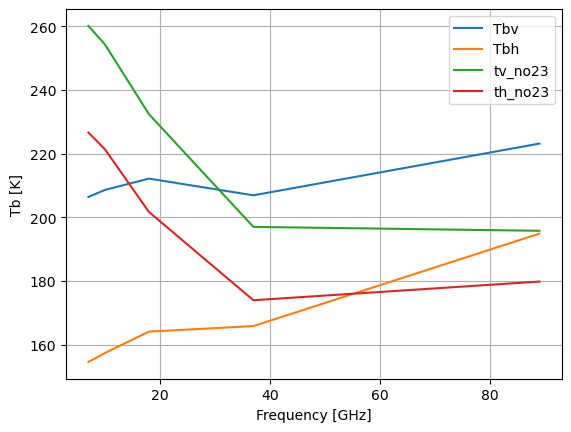

In [9]:
plt.plot(freqs,Tbv[0], label = 'Tbv')
plt.plot(freqs,Tbh[0], label = 'Tbh')
plt.plot(freqs,tv_no23[0], label = 'tv_no23')
plt.plot(freqs,th_no23[0], label = 'th_no23')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Tb [K]')
plt.legend()
plt.grid()
plt.show()

In [10]:
# Get values from file
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import xarray as xr

import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

fn = '../Data/iceh.2011-01.nc'
ds = nc.Dataset(fn)
#print(ds.variables.keys()) # get all variable names

In [11]:
# Gets the unique values for hi rounded.
hi_all = ds['hi'][0,:,:]
ok = np.unique(hi_all[84].round(decimals=4))
print(ok)

TOL = 0.05
test = np.unique(np.floor(hi_all/TOL).astype(int))*TOL
print(test.round(decimals=2))
print(np.size(test))

[0.0 9.999999747378752e-05 0.0003000000142492354 0.0006000000284984708
 0.0008999999845400453 0.0010000000474974513 0.0010999999940395355
 0.0012000000569969416 0.0015999999595806003 0.0024999999441206455
 0.004000000189989805 0.0066999997943639755 0.007899999618530273
 0.013799999840557575 0.026900000870227814 0.0272000003606081
 0.030799999833106995 0.03440000116825104 0.03720000013709068
 0.04050000011920929 0.04170000180602074 0.042500000447034836 --]
[0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75
 0.8 0.85 0.9 0.95 1.0 1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55
 1.6 1.65 1.7 1.75 1.8 1.85 1.9 1.95 2.0 2.05 2.1 2.15 2.2 2.25 2.3 2.35
 2.4 2.45 2.5 2.55 2.6 2.65 2.7 2.75 2.8 2.85 2.9 2.95 3.0 3.05 3.1 3.15
 3.2 3.25 3.3 3.35 3.4 3.45 3.5 3.55 3.6 3.65 3.7 3.75 3.8 3.85 3.9 3.95
 4.0 4.05 4.1 4.15 4.25 4.3 4.4 4.5 4.55 4.6 4.65 4.7 4.75 4.8 4.9 5.0 5.3
 5.35 5.5 5.6 5.85 6.0 --]
103


In [12]:
lat = ds.variables["TLAT"][:]
lon = ds.variables["TLON"][:]
hs   = ds.variables["hs"][0,:,:]
hi   = ds.variables["hi"][0,:,:]
Tinz = ds.variables["Tinz"][0,0,:,:]
Tsnz = ds.variables["Tsnz"][0,0,:,:]

In [13]:
x, y = 402,41
print(hi[x,y])
print(hs[x,y])
print(Tinz[x,y])
print(Tsnz[x,y])

1.01108
0.09432235
-7.0011554
59.658024


In [29]:
# Append all used data
hs_ = []
hi_ = []
Tinz_ = []
Tsnz_ = []

for x in range(lat.shape[1]):
    if x >= 100: break
        
    for y in range(lat.shape[0]):
        if y >= 400: break
            
        if hs[y,x] != np.nan:
            hs_ = np.append(hs_,hs[y,x])
            hi_ = np.append(hi_,hi[y,x])
            Tsnz_ = np.append(Tsnz_,Tsnz[y,x])
            Tinz_ = np.append(Tinz_,Tinz[y,x])

In [30]:
print(np.size(hs))
print(np.size(hs_))

693528
12055


In [31]:
good = []
test = smrtV

for i in range(5):
    try:
        print(i)
        good = np.concatenate([test,good],axis=0)
    except:
        print('start')
        good = test
        
print(np.shape(good))
print(good)


0
start
1
2
3
4
(5, 5)
[[265.91600149 261.3824048  242.12954304 210.13987079 203.51205571]
 [265.91600149 261.3824048  242.12954304 210.13987079 203.51205571]
 [265.91600149 261.3824048  242.12954304 210.13987079 203.51205571]
 [265.91600149 261.3824048  242.12954304 210.13987079 203.51205571]
 [265.91600149 261.3824048  242.12954304 210.13987079 203.51205571]]


In [32]:
status = np.array([])
print(status)
print(len(status))

[]
0


In [33]:
freqs = np.array([7,10,18,37,89])
leaderboard = []

smrtV_,smrtH_ = [],[]
TbV_,TbH_ = [],[]
 
ice_type = 'firstyear' # firstyear or multiyear sea ice
iceConc = 1

for i in range(len(status),np.size(hs_),1):
        
    if i != -1:
        print('Now working on data point {}'.format(i))
        snowDepth = hs_[i] # HS
        iceThickness = hi_[i] # HI
        surfTemp = Tsnz_[i] + 273.15 # Tsnz in kelvin
    
        try:
            smrtV,smrtH = run_smrt(snowDepth,iceThickness,surfTemp,iceType)
            TbV,TbH = tiepoint(snowDepth,iceThickness,surfTemp,iceConc)
        
            score = abs(smrtV - TbV) + abs(smrtH - TbH)
            leaderboard = np.append(leaderboard,np.mean(score))
            
            # Save the brightness temperature in arrays
            try:
                smrtV_ = np.concatenate((smrtV_,smrtV))
                smrtH_ = np.concatenate((smrtH_,smrtH))
                TbV_   = np.concatenate((TbV_,TbV))
                TbH_   = np.concatenate((TbH_,TbH))
                
            except: # Runs the first time
                smrtV_ = smrtV
                smrtH_ = smrtH
                TbV_   = TbV
                TbH_   = TbH
                
            # Run limit
            if len(leaderboard) >= 20:
                print('\n -=- Done -=- \n')
                break
                
            status = np.append(status, True)
            
        except:
            print('Failed')
            status = np.append(status, False)
            pass

Now working on data point 0
Failed
Now working on data point 1
Failed
Now working on data point 2
Failed
Now working on data point 3
Failed
Now working on data point 4
Failed
Now working on data point 5
Failed
Now working on data point 6
Failed
Now working on data point 7
Failed
Now working on data point 8
Failed
Now working on data point 9
Failed
Now working on data point 10
Failed
Now working on data point 11
Failed
Now working on data point 12
Failed
Now working on data point 13
Failed
Now working on data point 14
Failed
Now working on data point 15
Failed
Now working on data point 16
Failed
Now working on data point 17
Failed
Now working on data point 18
Failed
Now working on data point 19
Failed
Now working on data point 20
Failed
Now working on data point 21
Failed
Now working on data point 22
Failed
Now working on data point 23
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1EA897F0>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001DC1EA897F0>
SUBSTRATE: <smrt.su

In [25]:
status

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
smrtV_

[]

In [27]:
winner = np.where(leaderboard == min(leaderboard))
winner

ValueError: min() arg is an empty sequence

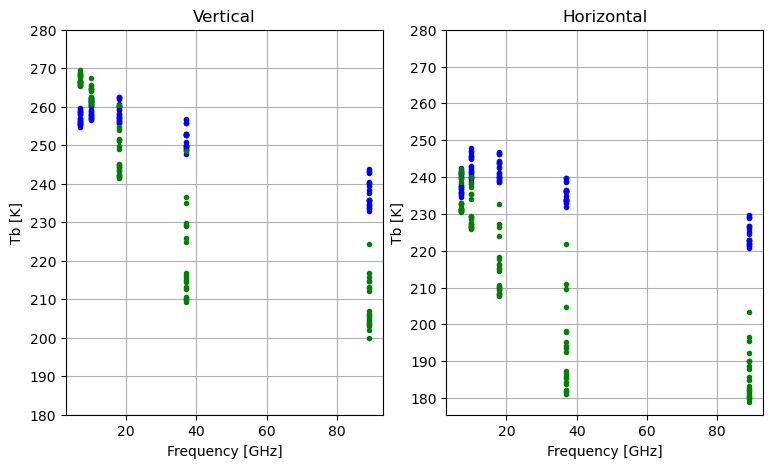

In [22]:
freqs = np.array([[7,10,18,37,89]])

index = np.arange(20)

fig = plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.title('Vertical')
plt.plot(freqs[index*0],TbV_[index],'.b', label = 'Tb_V')
plt.plot(freqs[index*0],smrtV_[index],'.g', label = 'smrt_V')
plt.yticks(np.arange(180,285,10))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Tb [K]')
#plt.legend();
plt.grid()

plt.subplot(1,2,2)
plt.title('Horizontal')
plt.plot(freqs[index*0],TbH_[index],'.b', label = 'Tb_H')
plt.plot(freqs[index*0],smrtH_[index],'.g', label = 'smrt_H')
plt.yticks(np.arange(180,285,10))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Tb [K]')
#plt.legend();
plt.grid()